# Emojifier

In this project, I used word vector representations to build an emojifier.

Rather than writing:
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"

### Project Overview:
1. I first built a baseline model (Emojifier-V1) using word embeddings.
2. I then built a more sophisticated model (Emojifier-V2) that incorporates an LSTM.

## Table of Contents

- [Packages](#0)
- [1 - Baseline Model: Emojifier-V1](#1)
    - [1.1 - Dataset EMOJISET](#1-1)
    - [1.2 - Overview of the Emojifier-V1](#1-2)
    - [1.3 - Implementing Emojifier-V1](#1-3)
    - [1.4 - Implement the Model](#1-4)
    - [1.5 - Examining Test Set Performance](#1-5)
- [2 - Emojifier-V2: Using LSTMs in Keras](#2)
    - [2.1 - Model Overview](#2-1)
    - [2.2 Keras and Mini-batching](#2-2)
    - [2.3 - The Embedding Layer](#2-3)
    - [2.4 - Building the Emojifier-V2](#2-4)
    - [2.5 - Train the Model](#2-5)
- [3 - Acknowledgments](#3)

<a name='0'></a>
## Packages

Let's get started! Run the following cell to load the packages you're going to use.

In [ ]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from test_utils import *

%matplotlib inline

<a name='1'></a>
## 1 - Baseline Model: Emojifier-V1

<a name='1-1'></a>
### 1.1 - Dataset EMOJISET

I started by building a simple baseline classifier.

I have a small dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

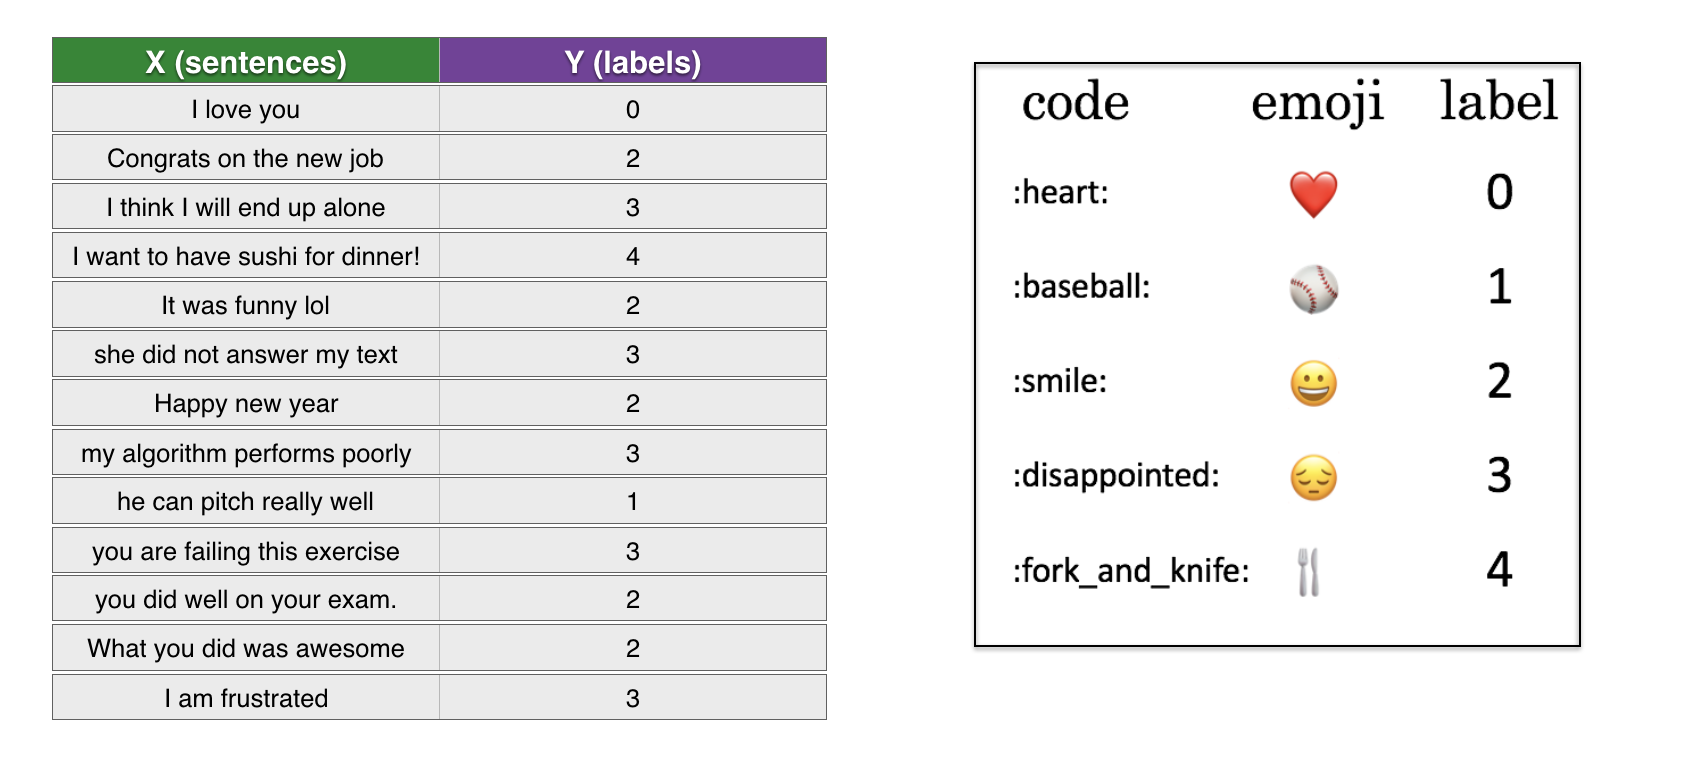

The dataset is split between training (127 examples) and testing (56 examples).

In [ ]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [ ]:
maxLen = len(max(X_train, key=len).split())

In [ ]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


<a name='1-2'></a>
### 1.2 - Overview of the Emojifier-V1

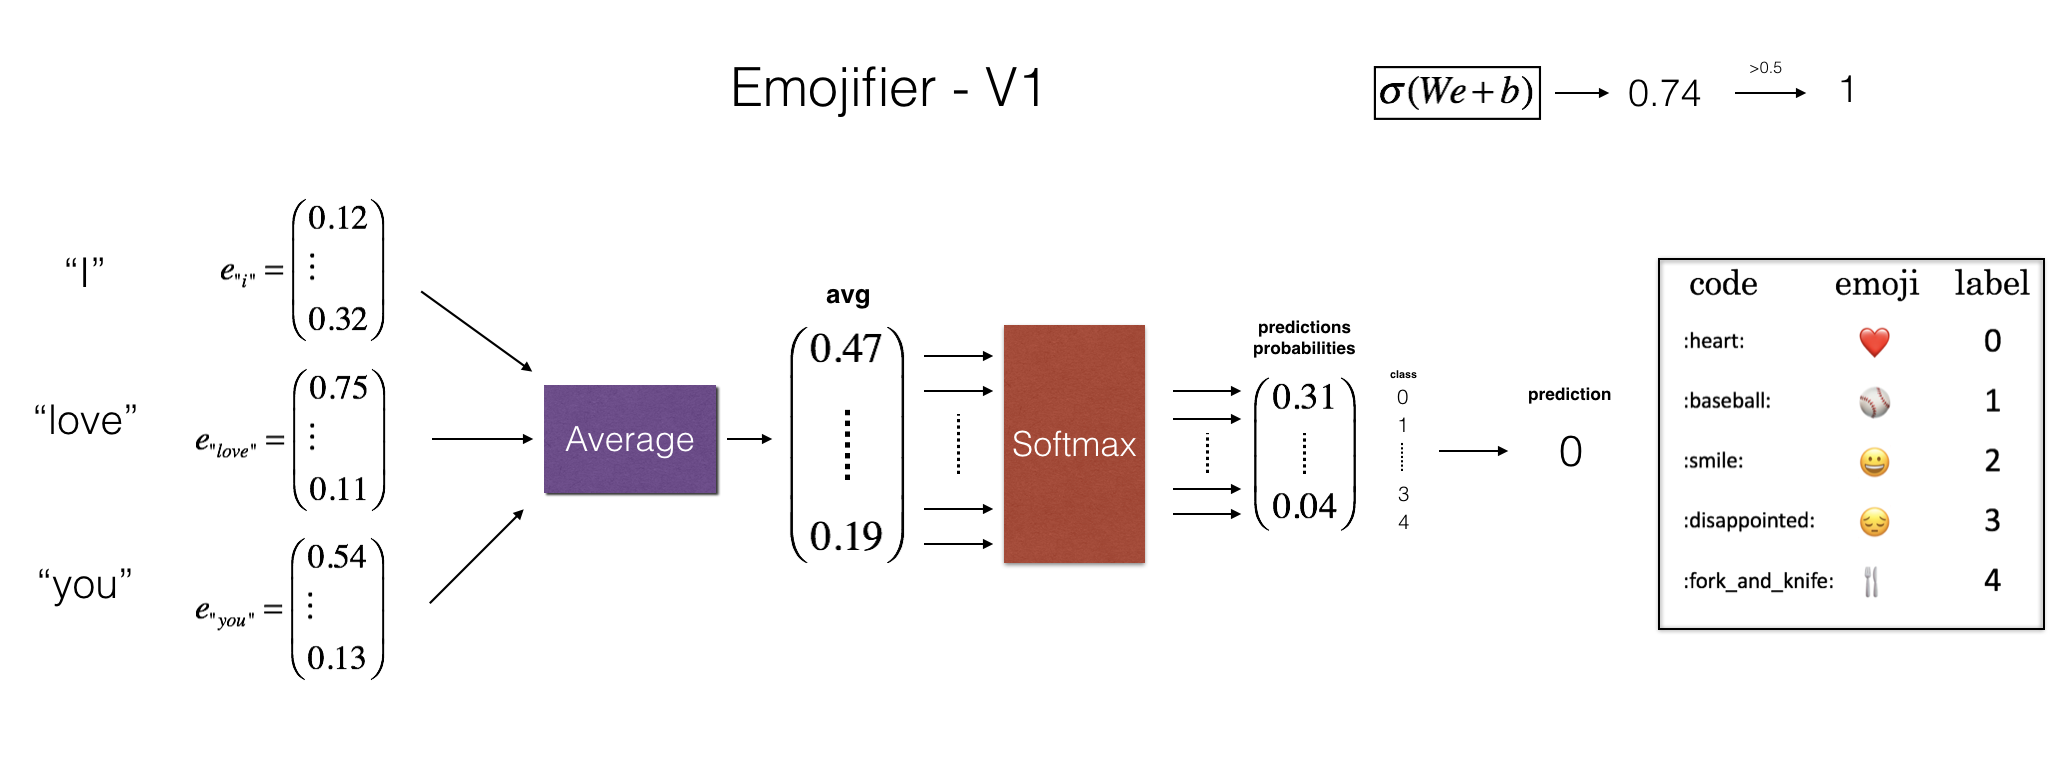


#### Inputs and Outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you").
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

#### One-hot Encoding
* To get my labels into a format suitable for training a softmax classifier, I converted $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$,
    * Each row is a one-hot vector giving the label of one example.
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`:

In [ ]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [ ]:
idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


<a name='1-3'></a>
### 1.3 - Implementing Emojifier-V1

As shown in Figure 2 (above), the first step is to:
* Convert each word in the input sentence into their word vector representations.
* Take an average of the word vectors.

I used pre-trained 50-dimensional GloVe embeddings.


In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [ ]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [ ]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.

    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation

    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    # Get a valid word contained in the word_to_vec_map.
    any_word = list(word_to_vec_map.keys())[0]
    print('any_word', any_word)

    # Step 1: Split sentence into list of lower case words
    words = [word.lower() for word in sentence.split()]
#     words = sentence.lower().split()
    print('words', words)

    # Initialize the average word vector, should have the same shape as the word vectors.
    avg = np.zeros(word_to_vec_map[any_word].shape)

    # Initialize count to 0
    count = 0

    # Step 2: average the word vectors. We can loop over the words in the list "words".
    for w in words:
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            # Increment count
            count +=1

    if count > 0:
        # Get the average. But only if count > 0
        avg = avg / count

    return avg




* Here were the equations I used to implement in the forward pass and to compute the cross-entropy cost:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels.

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$


In [ ]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.

    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations

    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """

    # Get a valid word contained in the word_to_vec_map
    any_word = list(word_to_vec_map.keys())[0]

    cost = 0

    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors

    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))

    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y)

    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples

            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = - np.sum(Y_oh[i] * np.log(a))

            # Compute gradients
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db

        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5, 0, 0, 5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and have drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is surprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))


(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 5)
<class 'numpy.ndarray'>


In [ ]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_w

words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', '

any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad',

any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i',

any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 

words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
an

any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any

any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', '

any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_

any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['

any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 

any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'ag

any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me'

any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words 

any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word t

any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
w

any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['

any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'perform

any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 's

any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any

any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words 

any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'you

any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 

any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word th

any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word 

any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
w

any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word t

any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words 

any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
wo

any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', '

any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 

any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am

any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 

any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
w

any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words [

any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 

any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_

any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss',

any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words

any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'no

any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said',

any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i'

any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words

any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is',

any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever'

any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any

any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 

any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['

any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 

any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i'

any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words 

words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word 

any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word 

any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'dat

any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do',

any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words [

any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'ag

any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any

any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the'

any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words [

any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy',

any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you',

any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too'

any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
wo

any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['

any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'dat

any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love'

any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words 

any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my

any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['

any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad',

any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', '

any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my

any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['

any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words

any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'no

any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word 

any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any

any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is

any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'basebal

words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to

any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']


any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the


any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words [

any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_w

any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'som

any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like'

any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playi

any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
wor

any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i',

any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'perform

any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'som

any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any

any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
word

any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 

any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you',

any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_wor

any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a',

any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 

any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words 

any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['co

any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is

any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', '

any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', '

any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']

any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
wor

any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
word

any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was'

any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 

any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 

any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet

any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
word

any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['

any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cut

any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_wo

any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am

any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']


any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words 

words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']

any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever'

any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the

any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad',

any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 

any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do',

any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
a

any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'wil

any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cut

any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the'

words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i'

any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['thi

any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i',

any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'perform

any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
w

any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
w

any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
wo

any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['thi

words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', '

any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_w

any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulat

any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words 

any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i'

any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am'

any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', '

any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
w

any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my

any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words 

any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word t

any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am'

any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
word

any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'perform

any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word t

any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', '

any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word 

any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words [

any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
w

any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you',

any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am',

any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'pu

any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word t

any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy',

any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'appr

any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the

any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy',

any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', '

any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cut

any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'you

any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'c

any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
wo

any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad',

any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 

any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'perform

any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['y

any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet

any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
word

any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any

any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 

any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']

any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the

any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
word

any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 

any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulat

any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind',

any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures'

words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_wo

words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any

any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_

any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['

any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too'

any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best

any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 

any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i',

any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 

any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word 

any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
w

any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too'

any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like'

any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss',

any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words

any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 't

any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
wo

any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
wo

any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', '

any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
word

any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever'

any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word 

any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'th

words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']

any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', '

any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']

any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you',

words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so'

any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best

any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['

any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you',

any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
w

any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'basebal

any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words

any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 

any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 

any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'you

any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 't

any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'm

any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and'

any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss',

words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 

any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 

any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 

any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_wor

any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do',

any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'd

any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me'

any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'you

any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
wor

any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'wil

any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', '

any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']

any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['

any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
wo

any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the

any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', '

any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word

any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', '

words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have

any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words [

any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'appr

any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word t

any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', '

any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'pu

any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'you

any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet

any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
word

any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
a

any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'no

any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
word

any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'you

any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 

any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words [

any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
w

any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me

any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', '

any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 

any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['

any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
wor

any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
word

any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'ag

any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated

any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the'

any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 

any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'c

any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too'

any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said',

any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and'

any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what',

words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the


any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word th

any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'h

any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
wo

any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best

any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words [

any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy',

any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', '

any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'wil

any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cut

any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', '

any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'dat

any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
word

any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word

any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'm

any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulat

words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the

any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
w

any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 

any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my

any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the

any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
w

any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
a

any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_w

words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'di

any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word 

any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
w

any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word

any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 's

any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
word

any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what', 'a', 'fun', 'moment']
any_word the
words ['i', 'want', 'to', 'have', 'sushi', 'for', 'dinner']
any_word the
words ['i', 'am', 'very', 'disappointed']
any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', '

any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 

words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job

any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_wo

any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words

any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words [

words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_

any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the', 'baby', 'is', 'adorable']
any_word the
words ['i', 'was', 'waiting', 'for', 'her', 'for', 'two', 'hours']
any_word the
words ['funny']
any_word the
words ['i', 'like', 'it', 'when', 'people', 'smile']
any_word the
words ['i', 'love', 'dogs']
any_word the
words ['they', 'are', 'so', 'kind', 'and', 'friendly']
any_word the
words ['so', 'bad', 'that', 'you', 'cannot', 'come', 'with', 'us']
any_word the
words ['he', 'likes', 'baseball']
any_word the
words ['i', 'am', 'so', 'impressed', 'by', 'your', 'dedication', 'to', 'this', 'project']
any_word the
words ['i', 'am', 'at', 'the', 'baseball', 'game']
any_word the
words ['bravo']
any_word the
words ['what',

any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy',

any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word th

any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too'

any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'ag

any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my

any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
wo

any_word the
words ['he', 'can', 'not', 'do', 'anything']
any_word the
words ['lol']
any_word the
words ['lets', 'have', 'food', 'together']
any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words

any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is',

any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love'

any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words 

any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word 

any_word the
words ['she', 'is', 'so', 'cute']
any_word the
words ['miss', 'you', 'my', 'dear']
any_word the
words ['i', 'am', 'looking', 'for', 'a', 'date']
any_word the
words ['i', 'am', 'frustrated']
any_word the
words ['i', 'lost', 'my', 'wallet']
any_word the
words ['you', 'failed', 'the', 'midterm']
any_word the
words ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny']
any_word the
words ['do', 'you', 'want', 'to', 'give', 'me', 'a', 'hug']
any_word the
words ['who', 'is', 'playing', 'in', 'the', 'final']
any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'th

any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 'text']
any_word the
words ['your', 'stupidity', 'h

any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and'

any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word the
words ['i', 'like', 'you', 'a', 'lot']
any_word the
words ['i', 'miss', 'him']
any_word the
words ['my', 'dog', 'just', 'had', 'a', 'few', 'puppies']
any_word the
words ['i', 'hate', 'him']
any_word the
words ['i', 'want', 'chinese', 'food']
any_word the
words ['cookies', 'are', 'good']
any_word the
words ['her', 'smile', 'is', 'so', 'charming']
any_word the
words ['bravo', 'for', 'the', 'announcement', 'it', 'got', 'a', 'lot', 'of', 'traction']
any_word the
words ['she', 'plays', 'baseball']
any_word the
words ['he', 'did', 'an', 'amazing', 'job']
any_word the
words ['the'

any_word the
words ['she', 'is', 'happy']
any_word the
words ['you', 'are', 'not', 'qualified', 'for', 'this', 'position']
any_word the
words ['i', 'love', 'my', 'dad']
any_word the
words ['this', 'guy', 'was', 'such', 'a', 'joke']
any_word the
words ['good', 'joke']
any_word the
words ['this', 'specialization', 'is', 'great']
any_word the
words ['you', 'could', 'not', 'solve', 'it']
any_word the
words ['i', 'am', 'so', 'happy', 'for', 'you']
any_word the
words ['congrats', 'on', 'the', 'new', 'job']
any_word the
words ['i', 'am', 'proud', 'of', 'you', 'forever']
any_word the
words ['i', 'want', 'to', 'eat']
any_word the
words ['that', 'catcher', 'sucks']
any_word the
words ['the', 'first', 'base', 'man', 'got', 'the', 'ball']
any_word the
words ['this', 'is', 'bad']
any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures'

any_word the
words ['you', 'did', 'not', 'do', 'your', 'homework']
any_word the
words ['i', 'will', 'have', 'a', 'cheese', 'cake']
any_word the
words ['do', 'you', 'have', 'a', 'ball']
any_word the
words ['the', 'lectures', 'are', 'great', 'though']
any_word the
words ['are', 'you', 'down', 'for', 'baseball', 'this', 'afternoon']
any_word the
words ['what', 'are', 'the', 'rules', 'of', 'the', 'game']
any_word the
words ['i', 'am', 'always', 'working']
any_word the
words ['where', 'is', 'the', 'stadium']
any_word the
words ['she', 'is', 'the', 'cutest', 'person', 'i', 'have', 'ever', 'seen']
any_word the
words ['vegetables', 'are', 'healthy']
any_word the
words ['he', 'is', 'handsome']
any_word the
words ['too', 'bad', 'that', 'you', 'were', 'not', 'here']
any_word the
words ['you', 'are', 'a', 'loser']
any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
a

any_word the
words ['i', 'love', 'indian', 'food']
any_word the
words ['who', 'is', 'down', 'for', 'a', 'restaurant']
any_word the
words ['he', 'had', 'to', 'make', 'a', 'home', 'run']
any_word the
words ['i', 'am', 'ordering', 'food']
any_word the
words ['what', 'is', 'wrong', 'with', 'you']
any_word the
words ['i', 'love', 'you']
any_word the
words ['great', 'job']
any_word the
words ['never', 'talk', 'to', 'me', 'again']
any_word the
words ['i', 'am', 'proud', 'of', 'your', 'achievements']
any_word the
words ['it', 'is', 'the', 'worst', 'day', 'in', 'my', 'life']
any_word the
words ['miss', 'you', 'so', 'much']
any_word the
words ['food', 'is', 'life']
any_word the
words ['i', 'love', 'you', 'mum']
any_word the
words ['stop', 'saying', 'bullshit']
any_word the
words ['congratulations', 'on', 'your', 'acceptance']
any_word the
words ['the', 'assignment', 'is', 'too', 'long']
any_word the
words ['i', 'want', 'to', 'go', 'play']
any_word the
words ['she', 'did', 'not', 'answer', 'my', 

words ['your', 'stupidity', 'has', 'no', 'limit']
any_word the
words ['how', 'many', 'points', 'did', 'he', 'score']
any_word the
words ['my', 'algorithm', 'performs', 'poorly']
any_word the
words ['i', 'got', 'approved']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['sounds', 'like', 'a', 'fun', 'plan', 'ha', 'ha']
any_word the
words ['no', 'one', 'likes', 'him']
any_word the
words ['the', 'game', 'just', 'finished']
any_word the
words ['i', 'will', 'celebrate', 'soon']
any_word the
words ['so', 'sad', 'you', 'are', 'not', 'coming']
any_word the
words ['she', 'is', 'my', 'dearest', 'love']
any_word the
words ['good', 'job']
any_word the
words ['it', 'was', 'funny', 'lol']
any_word the
words ['candy', 'is', 'life']
any_word the
words ['the', 'chicago', 'cubs', 'won', 'again']
any_word the
words ['i', 'am', 'hungry']
any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 

any_word the
words ['i', 'am', 'so', 'excited', 'to', 'see', 'you', 'after', 'so', 'long']
any_word the
words ['you', 'did', 'well', 'on', 'you', 'exam']
any_word the
words ['lets', 'brunch', 'some', 'day']
any_word the
words ['he', 'is', 'so', 'cute']
any_word the
words ['how', 'dare', 'you', 'ask', 'that']
any_word the
words ['do', 'you', 'want', 'to', 'join', 'me', 'for', 'dinner']
any_word the
words ['i', 'said', 'yes']
any_word the
words ['she', 'is', 'attractive']
any_word the
words ['you', 'suck']
any_word the
words ['she', 'smiles', 'a', 'lot']
any_word the
words ['he', 'is', 'laughing']
any_word the
words ['she', 'takes', 'forever', 'to', 'get', 'ready']
any_word the
words ['french', 'macaroon', 'is', 'so', 'tasty']
any_word the
words ['we', 'made', 'it']
any_word the
words ['i', 'am', 'excited']
any_word the
words ['i', 'adore', 'my', 'dogs']
any_word the
words ['congratulations']
any_word the
words ['this', 'girl', 'was', 'mean']
any_word the
words ['you', 'two', 'are', 'cut

any_word the
words ['you', 'two', 'are', 'cute']
any_word the
words ['my', 'code', 'is', 'working', 'but', 'the', 'grader', 'gave', 'me', 'zero']
any_word the
words ['this', 'joke', 'is', 'killing', 'me', 'haha']
any_word the
words ['do', 'you', 'like', 'pizza']
any_word the
words ['you', 'got', 'a', 'down', 'grade']
any_word the
words ['i', 'missed', 'you']
any_word the
words ['i', 'think', 'i', 'will', 'end', 'up', 'alone']
any_word the
words ['i', 'got', 'humiliated', 'by', 'my', 'sister']
any_word the
words ['you', 'are', 'awful']
any_word the
words ['i', 'cooked', 'meat']
any_word the
words ['this', 'is', 'so', 'funny']
any_word the
words ['lets', 'exercise']
any_word the
words ['he', 'is', 'the', 'best', 'player']
any_word the
words ['i', 'am', 'going', 'to', 'the', 'stadium']
any_word the
words ['you', 'are', 'incredibly', 'intelligent', 'and', 'talented']
any_word the
words ['stop', 'shouting', 'at', 'me']
any_word the
words ['who', 'is', 'your', 'favorite', 'player']
any_word 

In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


In [ ]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄



* Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before.
* Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*.

#### Word Ordering isn't Considered in this Model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy"

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy."

#### Confusion Matrix
* Printing the confusion matrix helps understand which classes are more difficult for your model.
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


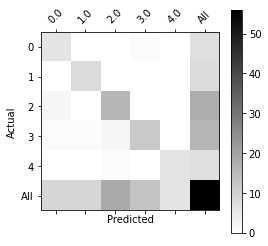

In [ ]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

<font color='blue'>
- Even with a mere 127 training examples, we can get a reasonably good model for emojifying.
    - This is due to the generalization power word vectors gives you.
- Emojify-V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"*
    - It doesn't understand combinations of words.
    - It just averages all the words' embedding vectors together, without considering the ordering of words.
</font>
    
**I improved upon this in Phase 2 of this project.**

<a name='2'></a>
## 2 - Emojifier-V2: Using LSTMs in Keras

Here, I built an LSTM model that takes word **sequences** as input. This model will be able to account for word ordering.

Emojifier-V2 will continue to use pre-trained word embeddings to represent words. We'll feed word embeddings into an LSTM, and the LSTM will learn to predict the most appropriate emoji.

### Packages


In [ ]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

<a name='2-1'></a>
### 2.1 - Model Overview

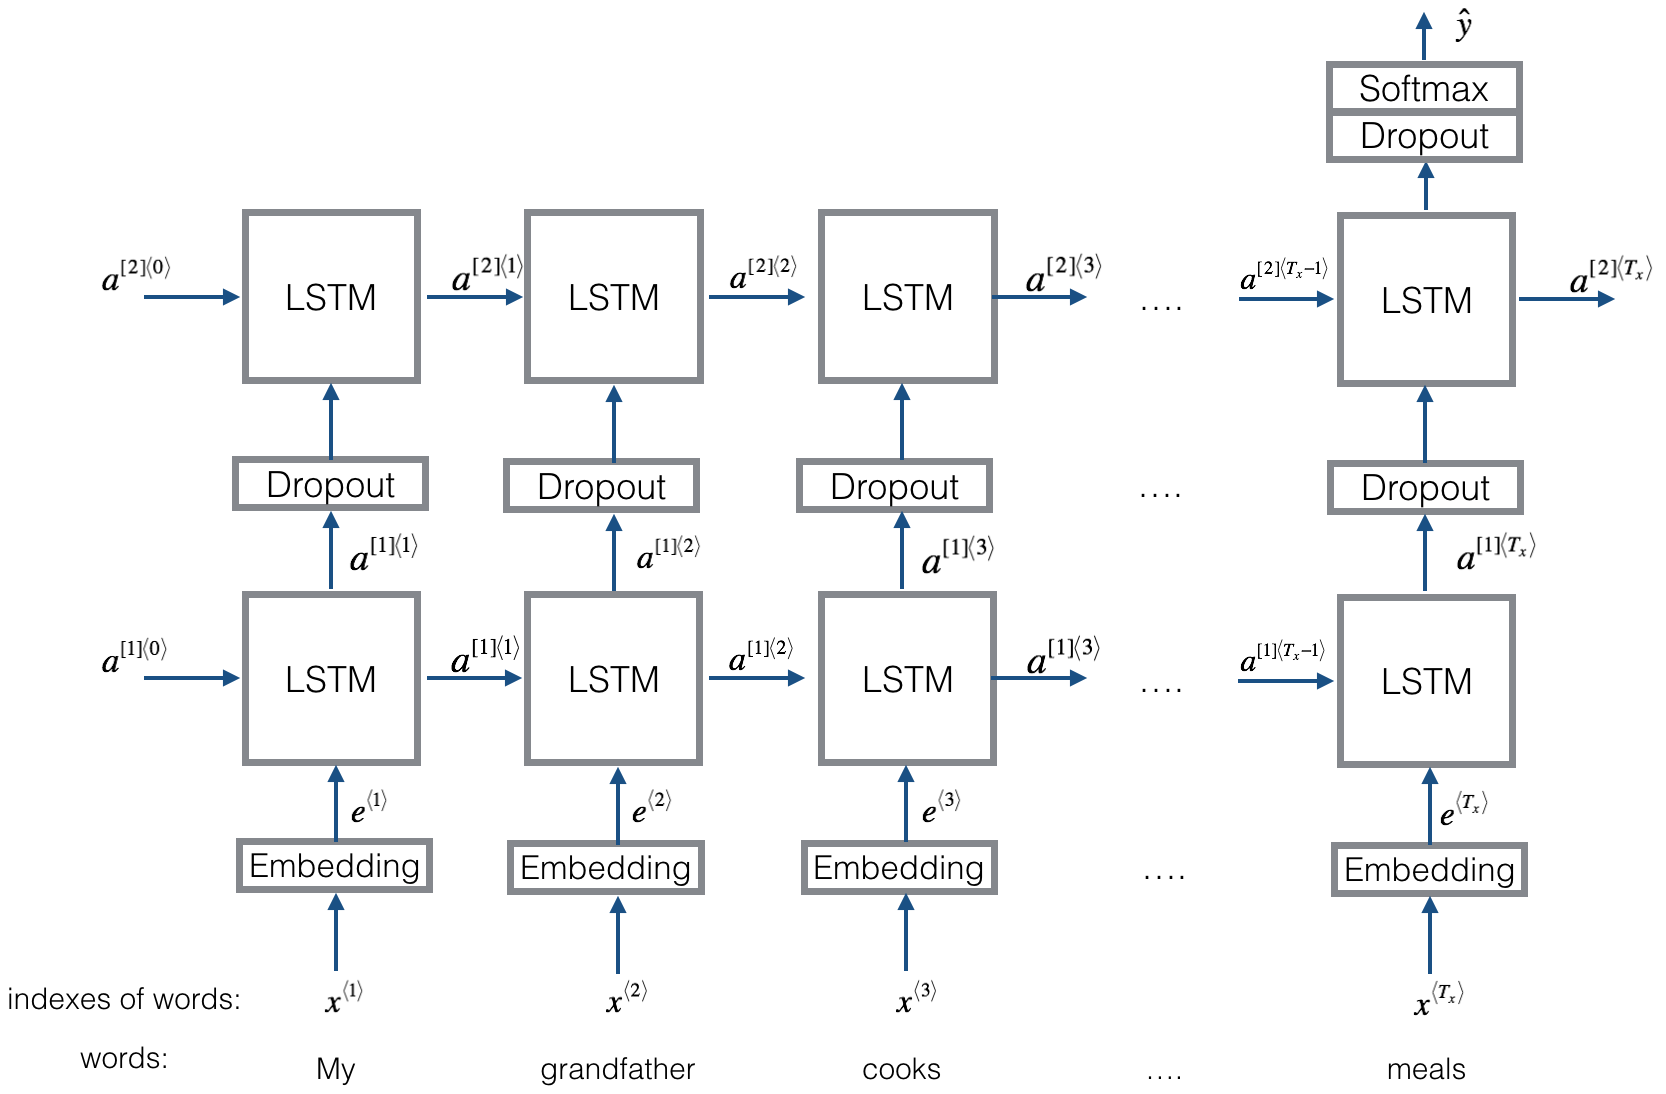

<a name='2-2'></a>
### 2.2 Keras and Mini-batching

In this step, I wanted ti train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the **same length**.

This is what allows vectorization to work: If we had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.
    
#### Padding Handles Sequences of Varying Length
* The common solution to handling sequences of **different length** is to use padding.  Specifically:
    * Set a maximum sequence length
    * Pad all sequences to have the same length.
    
#### Example of Padding:
* Given a maximum sequence length of 20, we could pad every sentence with "0"s so that each input sentence is of length 20.
* Thus, the sentence "I love you" would be represented as $(e_{I}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$.
* In this example, any sentences longer than 20 words would have to be truncated.
* One way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set.

<a name='2-3'></a>
### 2.3 - The Embedding Layer

In Keras, the embedding matrix is represented as a "layer."

* The embedding matrix maps word indices to embedding vectors.
    * The word indices are positive integers.
    * The embedding vectors are dense vectors of fixed size.
    * A "dense" vector is the opposite of a sparse vector. It means that most of its values are non-zero.  As a counter-example, a one-hot encoded vector is not "dense."
* The embedding matrix can be derived in two ways:
    * Training a model to derive the embeddings from scratch.
    * Using a pretrained embedding.
    
#### Using and Updating Pre-trained Embeddings
In this section, I created an [Embedding()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer in Keras

* I initialized the Embedding layer with GloVe 50-dimensional vectors.

#### Inputs and Outputs to the Embedding Layer

* The `Embedding()` layer's input is an integer matrix of size **(batch size, max input length)**.
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

* The figure shows the propagation of two example sentences through the embedding layer.
    * Both examples have been zero-padded to a length of `max_len=5`.
    * The word embeddings are 50 units in length.
    * The final dimension of the representation is  `(2,max_len,50)`.


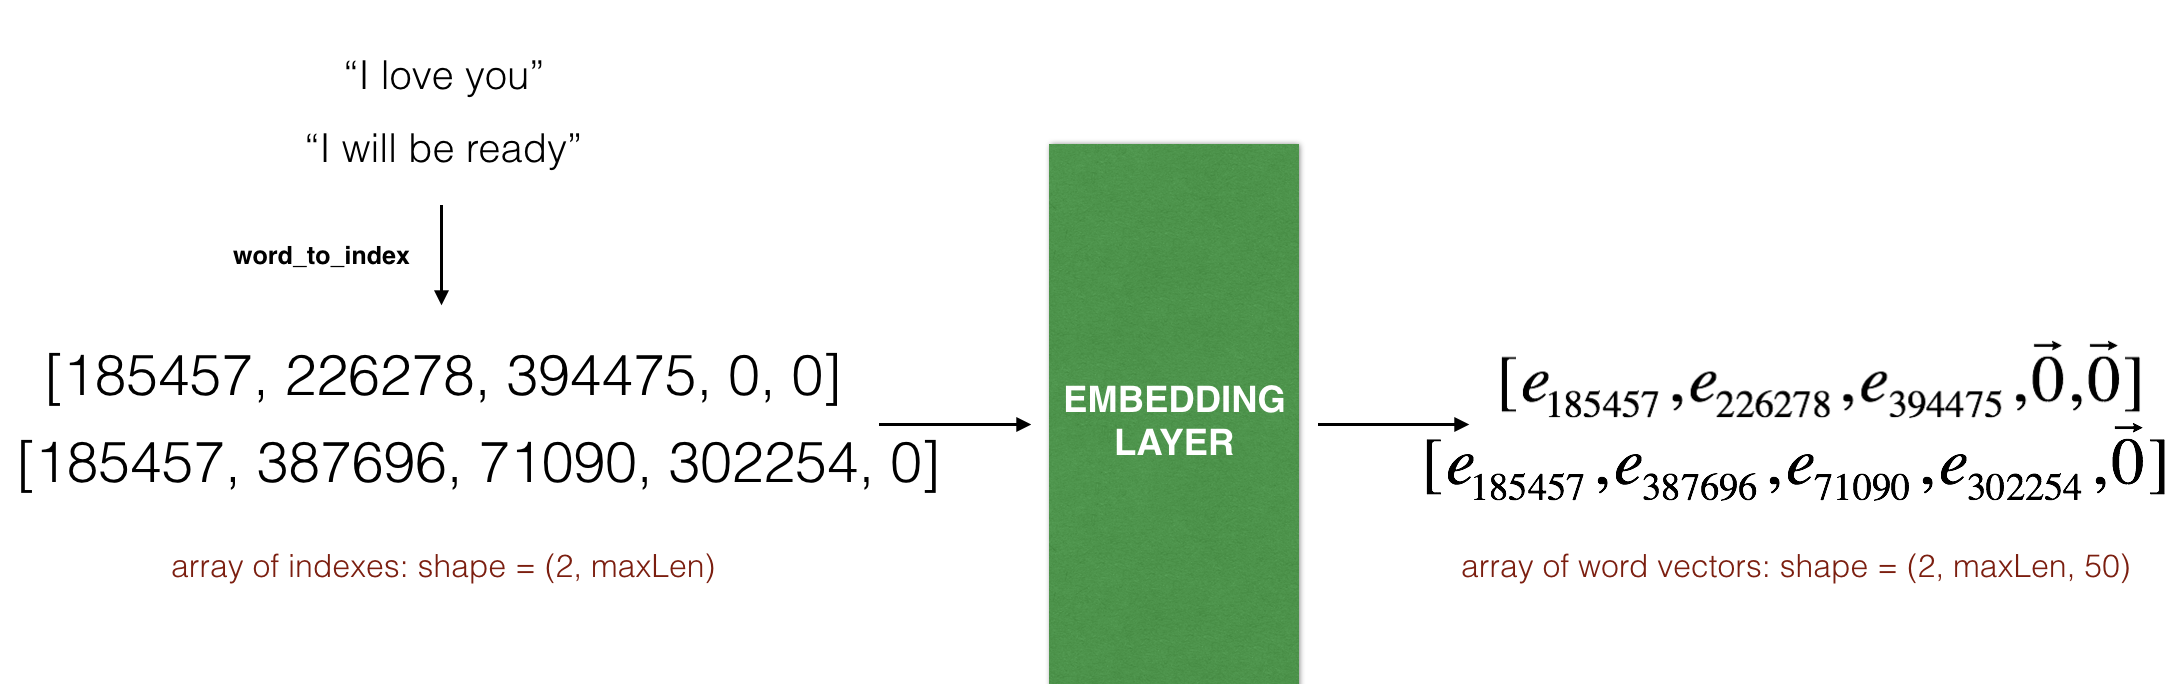

In [ ]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4).

    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. We can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]                                   # number of training examples

    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))

    for i in range(m):                               # loop over training examples

        # Convert the ith training sentence in lower case and split is into words
        sentence_words = X[i].lower().split()

        # Initialize j to 0
        j = 0

        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j += 1

    return X_indices

In [ ]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.

    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """

    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)

    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_size, emb_dim))

    # Step 2
    # Set each row "idx" of the embedding matrix to be
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = emb_dim, trainable = False)

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [ ]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


<a name='2-4'></a>
### 2.4 - Building the Emojifier-V2

In [ ]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.

    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """

    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=input_shape, dtype='int32')

    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(units=5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs= X)

    return model

In [ ]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<a name='2-5'></a>
### 2.5 - Train the Model

The Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). Thus, we have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [ ]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Fit the Keras model on `X_train_indices` and `Y_train_oh`, using `epochs = 50` and `batch_size = 32`.

In [ ]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 0s 25ms/step - loss: 1.5981 - accuracy: 0.2197
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 1.5217 - accuracy: 0.3106
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 1.4961 - accuracy: 0.3409
Epoch 4/50
5/5 [==============================] - 0s 34ms/step - loss: 1.4414 - accuracy: 0.3485
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 1.3331 - accuracy: 0.4318
Epoch 6/50
5/5 [==============================] - 0s 33ms/step - loss: 1.1726 - accuracy: 0.6364
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9915 - accuracy: 0.6742
Epoch 8/50
5/5 [==============================] - 0s 33ms/step - loss: 0.8393 - accuracy: 0.6894
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6916 - accuracy: 0.7500
Epoch 10/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6588 - accuracy: 0.7576
Epoch 11/50
5/5 [============

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.8036

Test accuracy =  0.8035714030265808


In [ ]:
# This code allows us to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: he got a very nice raise	❤️
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😄 prediction: he is a good friend	❤️
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:😞 prediction: go away	⚾
Expected emoji:😞 prediction: yesterday we lost again	⚾


In [ ]:
# Change the sentence below to see a prediction (making sure all the words are in the Glove embeddings)
x_test = np.array(['Phones are bad?'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

Phones are bad? 🍴


#### LSTM Version Accounts for Word Order
* The Emojify-V1 model did not predict "not feeling happy" correctly, but the implementation of Emojify-V2 got it right.
* The current model still isn't very robust at understanding negation (such as "not happy")
    * This is because the training set is small and doesn't have a lot of examples of negation.
    * If the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding more complex sentences.

<font color='blue'><b>What I Learned</b>:
- If we have an NLP task where the training set is small, using word embeddings can help the algorithm significantly.
- Word embeddings allow the model to work on words in the test set that may not even appear in the training set.
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be **padded** so that all the examples in a mini-batch have the **same length**.
    - An `Embedding()` layer can be initialized with pretrained values.
        - These values can be either fixed or trained further on a dataset.
        - If however a labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.   
    - `LSTM()` has a flag called `return_sequences` to decide if we would like to return every hidden states or only the last one.
    - We can use `Dropout()` right after `LSTM()` to regularize a network.

<a name='3'></a>
## 3 - Acknowledgments

Thanks to Alison Darcy and the Woebot team for their inspiration of this project.
* Woebot is a chatbot friend that is ready to speak with you 24/7.
* Part of Woebot's technology uses word embeddings to understand the emotions of what you say.
* You can chat with Woebot by going to http://woebot.io